(420, 640, 4)


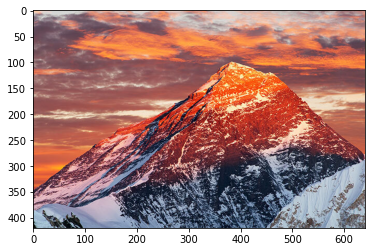

In [64]:
from PIL import Image
import numpy as np
import sys
import time
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
image = Image.open("mount.bmp") 
print(np.array(image).shape)
image = np.array(image)[:,:,:-1]
plt.imshow(image)

# 1 алгоритм: простая сортировка

In [90]:
def edge_padding(image, n):
    return np.pad(image, ((n, n), (n, n), (0, 0)), 'edge')

def simple_median_blur(image: np.array, r: int) -> np.array: 
    res = np.zeros_like(image)
    image = edge_padding(image, r)
    
    for i in range(r, image.shape[0] - r):
        for j in range(r, image.shape[1] - r):
            res[i - r][j - r] = np.median(image[i - r:i + r + 1, j - r:j + r + 1], axis=(0, 1))
    return res

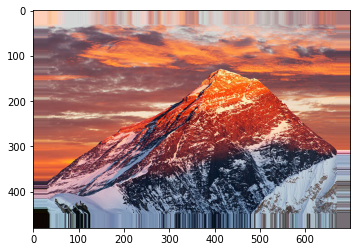

In [14]:
# паддинг выбираем такой
plt.imshow(edge_padding(image, 30))

In [21]:
res_simple = simple_median_blur(image, 15)
res_cv2 = cv.medianBlur(image, 31)

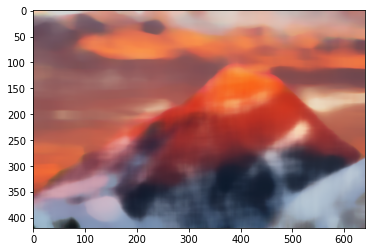

In [22]:
plt.imshow(res_simple)

In [23]:
# Проверяем, что метод из OpenCV работает так же
assert np.allclose(res_cv2, res_simple)

# 2 алгоритм: Huang et al.

In [25]:
def huang_median_blur(image: np.array, r: int) -> np.array:
    image = edge_padding(image, r)
    channels = []
    for i in range(3):
        channels.append(huang_median_blur_per_channel(image[:, :, i], r))
    return np.concatenate(channels, -1)
    
    
def huang_median_blur_per_channel(image: np.array, r: int):
    median_pos = (2 * r + 1) ** 2 // 2
    res = np.zeros((image.shape[0] - 2 * r, image.shape[1] - 2 * r))    
    for i in range(r, image.shape[0] - r):
        # инициализируем гистограмму
        hist = np.zeros(256)
        for b in image[i - r : i + r + 1, 0 : 2 * r + 1].reshape(-1):
            hist[b] += 1        
        less_median = 0
        median = 0                
        while less_median + hist[median] <= median_pos:
            less_median += hist[median]
            median += 1  
        res[i - r][0] = median                 
        for j in range(r + 1, image.shape[1] - r):
            left = image[i - r : i + r + 1, j - r - 1]
            right = image[i - r : i + r + 1, j + r]

            # убираем левый столбец и добавляем правый
            for k in range(0, 2 * r + 1):
                b = left[k]
                hist[b] -= 1
                if b < median:
                    less_median -= 1
                b = right[k]
                hist[b] += 1               
                if b < median:
                    less_median += 1
            if less_median > median_pos:
                while less_median > median_pos: 
                    median -= 1
                    less_median -= hist[median]
            else:
                while less_median + hist[median] <= median_pos:
                    less_median += hist[median]
                    median += 1            
            res[i - r][j - r] = median          
    return np.expand_dims(res, -1)

In [20]:
res_huang = huang_median_blur(image, 15)

In [24]:
# Проверяем, что метод из OpenCV работает так же
assert np.allclose(res_cv2, res_huang)

# 3 алгоритм: constant time O(1)

In [48]:
def find_median_in_hist(hist, median_pos):
        less_then_median = 0 
        median = 0
        while less_then_median + hist[median] <= median_pos:
            less_then_median += hist[median]
            median += 1
        return median

In [49]:
def constant_time_blur(image: np.array, r: int) -> np.array:
    """
    S. Perreault, and H. Patrick, “Median filtering in constant time.” IEEE transactions on image processing, 2007
    """
    image = edge_padding(image, r)
    channels = []
    for i in range(3):
        channels.append(constant_time_blur_per_channel(image[:, :, i], r))
    return np.concatenate(channels, -1)
    
    
def constant_time_blur_per_channel(image: np.array, r: int):
    median_pos = (2 * r + 1) ** 2 // 2
    res = np.zeros((image.shape[0] - 2 * r, image.shape[1] - 2 * r))
    
    def make_hist(arr):
        hist = np.zeros(256)
        for elem in arr:
            hist[elem] += 1
        return hist

    def shift_hist(arr):
        up = arr[0]
        down = arr[1]
        hist = arr[2:]
        hist[int(arr[0])] -= 1
        hist[int(arr[1])] += 1
        return hist

    hists = np.apply_along_axis(make_hist, 0, image[0:2 * r + 1, :]).T
    kernel_hist = np.sum(hists[:2 * r + 1], axis = 0) 
    
    # обрабатываем первую строчку
    res[0][0] = find_median_in_hist(kernel_hist, median_pos)
        
    for j in range(r + 1, image.shape[1] - r):
        kernel_hist += hists[j + r]
        kernel_hist -= hists[j - r - 1]
        res[0][j - r] = find_median_in_hist(kernel_hist, median_pos)
    
    # обрабатываем остальные строки
    for i in range(r + 1, image.shape[0] - r):
        # сдвигаем все гистограммы колонок на строчку ниже
        up = np.expand_dims(image[i - r - 1, :], -1)
        down = np.expand_dims(image[i + r], -1)
        hists = np.apply_along_axis(shift_hist, -1, np.concatenate((up, down, hists), -1))
        kernel_hist = np.sum(hists[:2 * r + 1], axis = 0)        
        res[i - r][0] = find_median_in_hist(kernel_hist, median_pos)
        for j in range(r + 1, image.shape[1] - r):
            kernel_hist += hists[j + r]
            kernel_hist -= hists[j - r - 1]
            res[i - r][j - r] = find_median_in_hist(kernel_hist, median_pos)
            
    return np.expand_dims(res, -1)

In [51]:
res_const = constant_time_blur(image, 15)

In [52]:
# Проверяем, что метод из OpenCV работает так же
assert np.allclose(res_cv2, res_const)

# Сравнение времени выполнения алгоритмов

In [59]:
simple_time = []
huang_time = []
const_time = []
opencv_time = []
for r in [1] + list(range(10, 101, 10)):
  print(f'Радиус фильтра: {r}')
  start = time.time()
  res1 = simple_median_blur(image, r)
  simple_time.append(time.time() - start)
  print(f"Время алгоритма простой сортировки: {simple_time[-1]}")

  start = time.time()
  res2 = huang_median_blur(image, r)
  huang_time.append(time.time() - start)
  print(f"Время алгоритма huang et al.: {huang_time[-1]}")

  start = time.time()
  res3 = constant_time_blur(image, r)
  const_time.append(time.time() - start)
  print(f"Время алгоритма const time O(1): {const_time[-1]}")
  
  start = time.time()
  res0 = cv.medianBlur(image, 2 * r + 1)
  opencv_time.append(time.time() - start)
  print(f"Время алгоритма из OpenCV: {opencv_time[-1]}")

  assert np.allclose(res1, res0)
  assert np.allclose(res2, res0)
  assert np.allclose(res3, res0)

Радиус фильтра: 1
Время алгоритма простой сортировки: 10.168175220489502
Время алгоритма huang et al.: 16.53916311264038
Время алгоритма const time O(1): 72.32237315177917
Время алгоритма из OpenCV: 0.0032625198364257812
Радиус фильтра: 10
Время алгоритма простой сортировки: 13.953761100769043
Время алгоритма huang et al.: 84.96622371673584
Время алгоритма const time O(1): 71.32995438575745
Время алгоритма из OpenCV: 0.03403639793395996
Радиус фильтра: 20
Время алгоритма простой сортировки: 23.413198471069336
Время алгоритма huang et al.: 163.0399889945984
Время алгоритма const time O(1): 71.25218439102173
Время алгоритма из OpenCV: 0.032929420471191406
Радиус фильтра: 30
Время алгоритма простой сортировки: 38.18710112571716
Время алгоритма huang et al.: 244.34699606895447
Время алгоритма const time O(1): 68.97085952758789
Время алгоритма из OpenCV: 0.03088974952697754
Радиус фильтра: 40
Время алгоритма простой сортировки: 57.80918025970459
Время алгоритма huang et al.: 327.61893177032

In [89]:

start = time.time()
res1 = simple_median_blur(image, 40)
t = time.time() - start
print(f"Время алгоритма простой сортировки: {t}")

Время алгоритма простой сортировки: 224.16320848464966


In [61]:
simple_time_ms_mps = np.array(simple_time) * 1000 * 1e6 / image.shape[0] / image.shape[1]
huang_time_ms_mps = np.array(huang_time) * 1000 * 1e6 / image.shape[0] / image.shape[1]
const_time_ms_mps = np.array(const_time) * 1000 * 1e6 / image.shape[0] / image.shape[1]
opencv_time_ms_mps = np.array(opencv_time) * 1000 * 1e6 / image.shape[0] / image.shape[1]

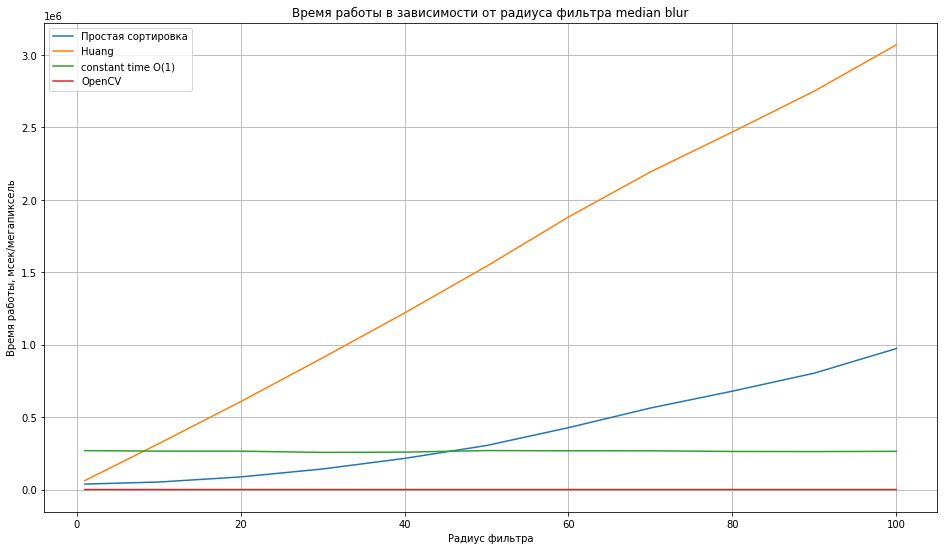

In [63]:
x = [1] + list(range(10, 101, 10))
plt.figure(figsize=(16, 9))
plt.plot(x, simple_time_ms_mps, label='Простая сортировка')
plt.plot(x, huang_time_ms_mps, label='Huang')
plt.plot(x, const_time_ms_mps, label='constant time O(1)')
plt.plot(x, opencv_time_ms_mps, label='OpenCV')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.xlabel('Радиус фильтра')
plt.title('Время работы в зависимости от радиуса фильтра median blur')
plt.grid()
plt.legend()
plt.show()

Из графиков видно, что huang линейно зависит от радиуса фильтра, а простая сортировка квадратично, покажем это наглядно, аппроксимируя эти графики соответствующими кривыми


In [65]:
def mapping1(values_x, a, b): 
    return a * values_x + b
 
def mapping2(values_x, a, b, c): 
    return a * values_x**2 + b * values_x + c

In [76]:
args, covar = curve_fit(mapping2, x, simple_time_ms_mps)
args2, covar2 = curve_fit(mapping1, x, huang_time_ms_mps)

график апроксимации простой сортировки: 75.09*x^2 + 2063.26*x + 23387.67
график апроксимации huang: 30688.53*x + 9870.08


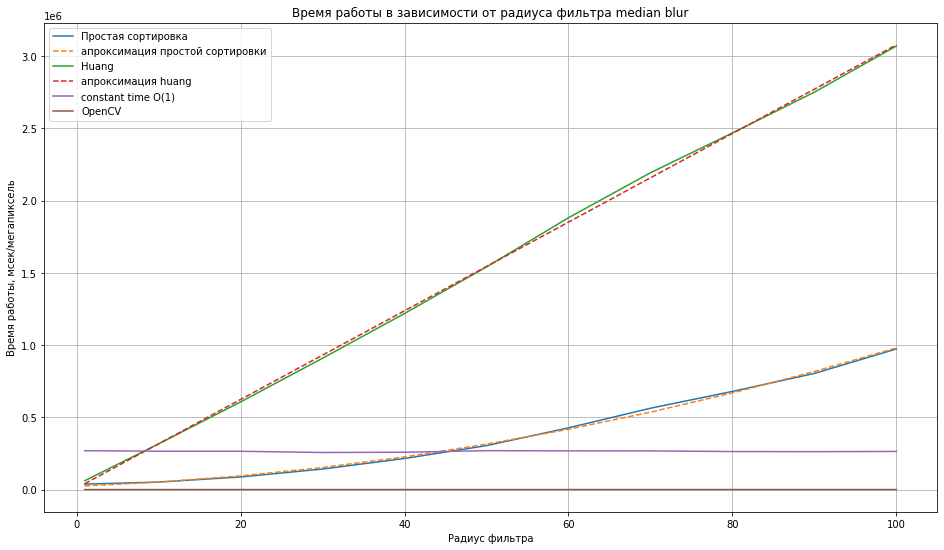

In [80]:

plt.figure(figsize=(16, 9))
plt.plot(x, simple_time_ms_mps, label='Простая сортировка')
plt.plot(x, mapping2(np.array(x), *args), label='апроксимация простой сортировки', linestyle = '--')
print(f"график апроксимации простой сортировки: {args[0]:.4}*x^2 + {args[1]:.6}*x + {args[2]:.7}")
plt.plot(x, huang_time_ms_mps, label='Huang')
plt.plot(x, mapping1(np.array(x), *args2), label='апроксимация huang', linestyle = '--')
print(f"график апроксимации huang: {args2[0]:.7}*x + {args2[1]:.6}")
plt.plot(x, const_time_ms_mps, label='constant time O(1)')
plt.plot(x, opencv_time_ms_mps, label='OpenCV')
plt.ylabel('Время работы, мсек/мегапиксель')
plt.xlabel('Радиус фильтра')
plt.title('Время работы в зависимости от радиуса фильтра median blur')
plt.grid()
plt.legend()
plt.show()

Теперь видно, что простой алгоритм работает квадратично. Может показаться, что Huang намного хуже чем простой и они пересекутся только при r равном около 200, но на самом деле в функции используется `np.median`, которая работает гораздо быстрее, чем обычная сортировка `np.sort`. Но при данной реализации алгоритмов, нужно использовать простой алгоритм при `r <= 44`, а при `r > 44` использовать constant time

Также мы можем сказать, что в библиотеке OpenCV используется алгоритм с константным временем, но реализован на более быстром языке программирования

Оценки фактической сложности:

- Простой алгоритм - `O(r^2)`

- Huang - `O(r)`

- Constant time - `O(1)`